In [1]:
file_path = '/home/krispy_noodles/SIT_Chatbot/assets/SIT User Study.xlsx'

In [ ]:
def preference():
    """
    Function to plot comparisons between Chatbot and Manual Search metrics from an Excel sheet,
    including average lines on the line graph and bar graph, using SIT-inspired colors.

    Parameters:
    - file_path: str, path to the Excel file.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # SIT-inspired color palette
    sit_colors = ['#FF1F1F', '#000000', '#FFFFFF', '#F0F0F0', '#808080']

    # Load the sheet
    df = pd.read_excel(file_path, sheet_name='Feedback')
    
    # Clean the DataFrame
    df_cleaned = df.dropna().reset_index(drop=True)
    
    # Standardize column names to avoid formatting issues 
    df_cleaned.columns = df_cleaned.columns.str.strip()
    
    # Count unique values for both categories
    end_study_preference = df_cleaned["Which do they prefer?"].value_counts()

        # Function to create pie chart with labels including total count and a black edge
    def plot_pie_chart(data, title, colors):
        labels = [f"{label} ({count})" for label, count in zip(data.index, data.values)]
        plt.figure(figsize=(6, 6))
        wedges, texts, autotexts = plt.pie(data, labels=labels, autopct='%1.1f%%', colors=colors,
                                           textprops={'fontsize': 11}, wedgeprops={'edgecolor': 'black'})
        plt.title(title, fontweight="bold")
        plt.show()

    # # Create labels with total numbers
    # labels = [f"{label} ({count})" for label, count in zip(end_study_preference.index, end_study_preference.values)]

    # # Plot pie chart for 'SIT Students'
    # plt.figure(figsize=(6, 6))

    plot_pie_chart(end_study_preference, "Which do they prefer?", [sit_colors[0], sit_colors[2]])

    # plt.pie(end_study_preference, labels=labels, autopct='%1.1f%%', colors=[sit_colors[0], sit_colors[4]], textprops={'fontsize': 11})
    # plt.title("Which do they prefer?", fontweight="bold")
    # plt.show()

In [ ]:
preference()

In [3]:
file_path = '/home/krispy_noodles/SIT_Chatbot/assets/SIT User Study.xlsx'

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Load the sheet
df = pd.read_excel(file_path, sheet_name='Feedback')

# Clean the DataFrame
df_cleaned = df.dropna().reset_index(drop=True)

df_cleaned=df_cleaned[df_cleaned["Which do they prefer?"] == "Chatbot"]

# Standardize column names to avoid formatting issues
df_cleaned.columns = df_cleaned.columns.str.strip()

# Extract participant IDs and responses
participant_ids = df_cleaned.iloc[:, 0].astype(str).tolist()

responses = df_cleaned["Why (if dont wish to include too is fine)/ any comments"].astype(str).tolist()

In [7]:
from dotenv import load_dotenv
import os
from langchain_openai import OpenAIEmbeddings

# Load environment variables from the .env file
load_dotenv("/home/krispy_noodles/SIT_Chatbot/.env")

# entering the creditials
embeddings_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=os.getenv("OPENAI_API_KEY")
)

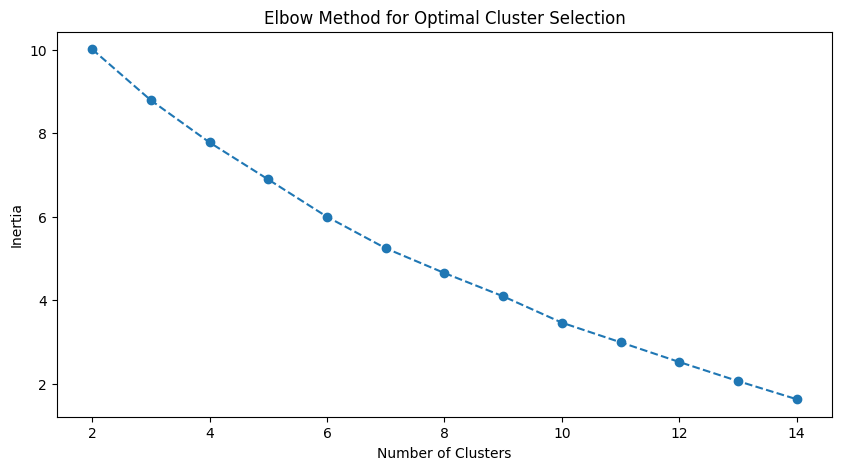

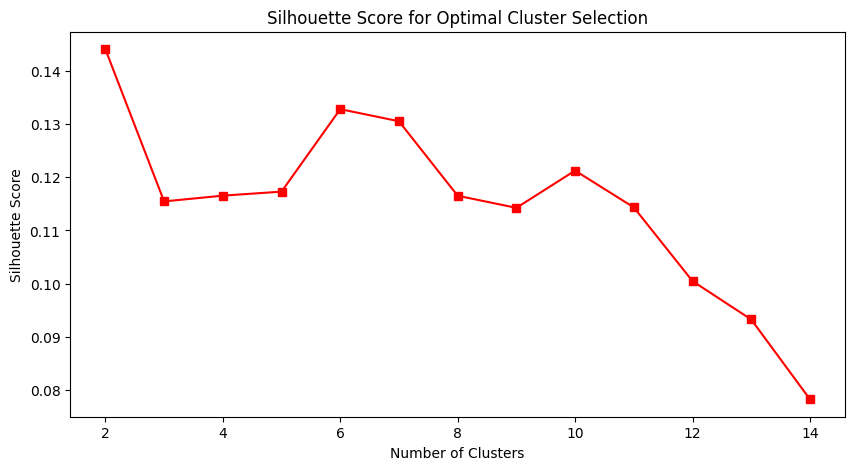

In [8]:
from langchain_openai import AzureOpenAIEmbeddings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Generate embeddings using Azure OpenAI
embeddings = np.array([embeddings_model.embed_query(response) for response in responses])

# Determine optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []
cluster_range = range(2, 15)  # Checking clusters from 2 to 20

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

# Plot Elbow Method (Inertia)
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Cluster Selection')
plt.show()

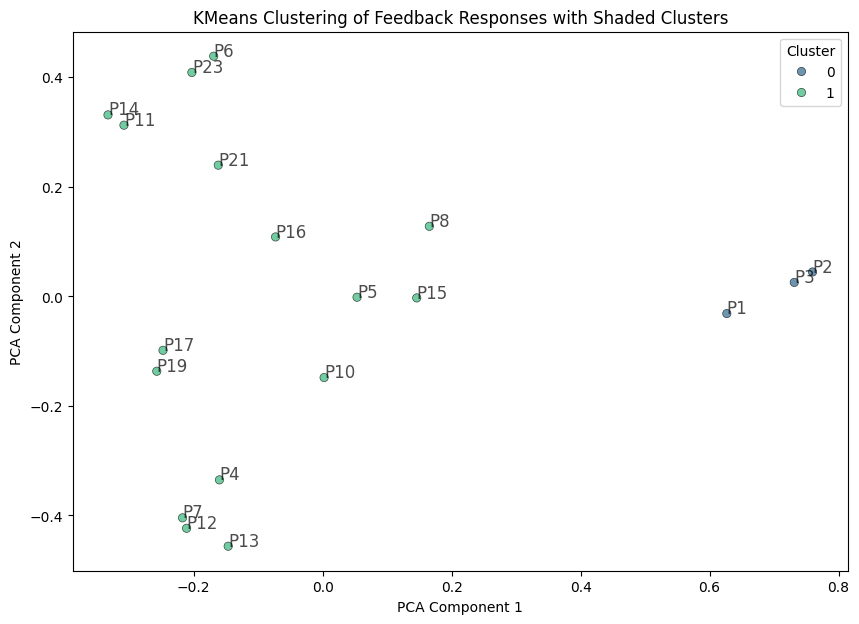

In [9]:
import seaborn as sns

# Choose optimal number of clusters (user can decide based on elbow method and silhouette score)
optimal_clusters = 2  # Change based on observation

# Apply KMeans Clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(embeddings)

# Convert to DataFrame for Seaborn plotting
df_plot = pd.DataFrame({'PCA1': reduced_vectors[:, 0], 'PCA2': reduced_vectors[:, 1], 'Cluster': labels, 'Participant ID': participant_ids})

# Plot the clustered responses in 2D space with shaded clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', alpha=0.7, edgecolor='k')

# Annotate points with participant IDs
for i, row in df_plot.iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Participant ID'], fontsize=12, alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clustering of Feedback Responses with Shaded Clusters")
plt.legend(title="Cluster")
plt.show()

# Create DataFrame to display results
df_result = pd.DataFrame({'Participant ID': participant_ids, 'Response': responses, 'Cluster': labels})
df_result.sort_values(by='Cluster', inplace=True)
df_result.reset_index(drop=True, inplace=True)

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute Sentiment Scores
sentiment_scores = []
sentiment_labels = []

for response in responses:
    score = analyzer.polarity_scores(response)["compound"]  # Compound Score (-1 to 1)
    sentiment_scores.append(score)

    # Assign sentiment label
    if score >= 0.05:
        sentiment_labels.append("Positive 😊")
    elif score <= -0.05:
        sentiment_labels.append("Negative 😡")
    else:
        sentiment_labels.append("Neutral 😐")

# Add Sentiment Scores to DataFrame
df_cleaned["Sentiment Score"] = sentiment_scores
df_cleaned["Sentiment Label"] = sentiment_labels

# Display the sentiment analysis results
import ace_tools as tools
tools.display_dataframe_to_user(name="Sentiment Analysis Results", dataframe=df_cleaned)
